In [43]:
from cogpred.utils.naming import make_run_path
import joblib
from cogpred.utils.configuration import get_config
from pathlib import Path

config = get_config()
dir = Path(config["output_dir"]) / "prediction"
ATLAS = "schaefer200"
k = 3

conn_dir = config["connectivity_matrices"]

In [44]:
import joblib
# TODO make eval dict to sort experiments
scores = []
names = []
for subdir in dir.iterdir():
    try:
        res = joblib.load(subdir / "test_scores.joblib")
    except FileNotFoundError:
        print(f"{subdir.name} has no available score")
        continue
    if "experimental-True" not in subdir.name:
        scores.append(res)
        names.append(subdir.name)

k-3_feat-series_experimental-True_atlas-schaefer200_winsize-128_batchsize-512_niter-20_stamp-2024-07-10-16:56 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-04 18:10:38 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 10:30:43 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 11:16:56 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 12:13:19 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:00:50 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:02:36 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:06:46 has no available score
k-3_feat-series_experimental-True_atlas-schaefer200_

## Display outer cv results

In [45]:
import pandas as pd
import seaborn as sns
def shorten(long_name):
    return long_name.split("_")[1].split("-")[1]

df = pd.DataFrame(scores, index=[name[9:] for name in names], columns=[f"split_{i+1}" for i in range(len(res))])
df

,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8
fc_atlas-schaefer200_groupkfold-True_net-allbrain,0.361941,0.375460,0.350978,0.325789,0.305397,0.298814,0.336853,0.325345
volumetry_atlas-schaefer200_experimental-False,0.478986,0.417284,0.319653,0.429589,0.443938,0.424431,0.360872,0.413831
dummy_experimental-False,0.274691,0.282486,0.261905,0.293333,0.246499,0.314700,0.285714,0.291209
fc_atlas-schaefer200_groupkfold-True_net-Default,0.352638,0.368678,0.343780,0.323266,0.311541,0.376377,0.390324,0.316162
fc_atlas-schaefer200_groupkfold-True_net-Limbic,0.378662,0.394759,0.313088,0.320193,0.333176,0.308583,0.327899,0.328943
fc_atlas-schaefer200_groupkfold-True_net-Limbic_inter-SomMot,0.303175,0.342593,0.309982,0.338265,0.350372,0.314110,0.370732,0.349282
fc_atlas-schaefer200_groupkfold-True_net-SomMot_inter-SomMot,0.365325,0.256410,0.316745,0.307818,0.292023,0.314903,0.334667,0.334156
fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default,0.329408,0.439057,0.369581,0.364598,0.304225,0.307899,0.310160,0.337863
fc_atlas-schaefer200_groupkfold-True_net-LimbicDorsAttn_inter-DefaultSomMotLimbicDorsAttn,0.293355,0.485137,0.373333,0.330441,0.284722,0.352460,0.294636,0.378958
fc_atlas-schaefer200_groupkfold-False_net-Default_inter-Default,0.401768,0.439057,0.313651,0.337499,0.287035,0.297800,0.314304,0.313238


In [46]:
df.mean(axis=1)

fc_atlas-schaefer200_groupkfold-True_net-allbrain                                            0.335072
volumetry_atlas-schaefer200_experimental-False                                               0.411073
dummy_experimental-False                                                                     0.281317
fc_atlas-schaefer200_groupkfold-True_net-Default                                             0.347846
fc_atlas-schaefer200_groupkfold-True_net-Limbic                                              0.338163
fc_atlas-schaefer200_groupkfold-True_net-Limbic_inter-SomMot                                 0.334814
fc_atlas-schaefer200_groupkfold-True_net-SomMot_inter-SomMot                                 0.315256
fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default                               0.345349
fc_atlas-schaefer200_groupkfold-True_net-LimbicDorsAttn_inter-DefaultSomMotLimbicDorsAttn    0.349130
fc_atlas-schaefer200_groupkfold-False_net-Default_inter-Default                   

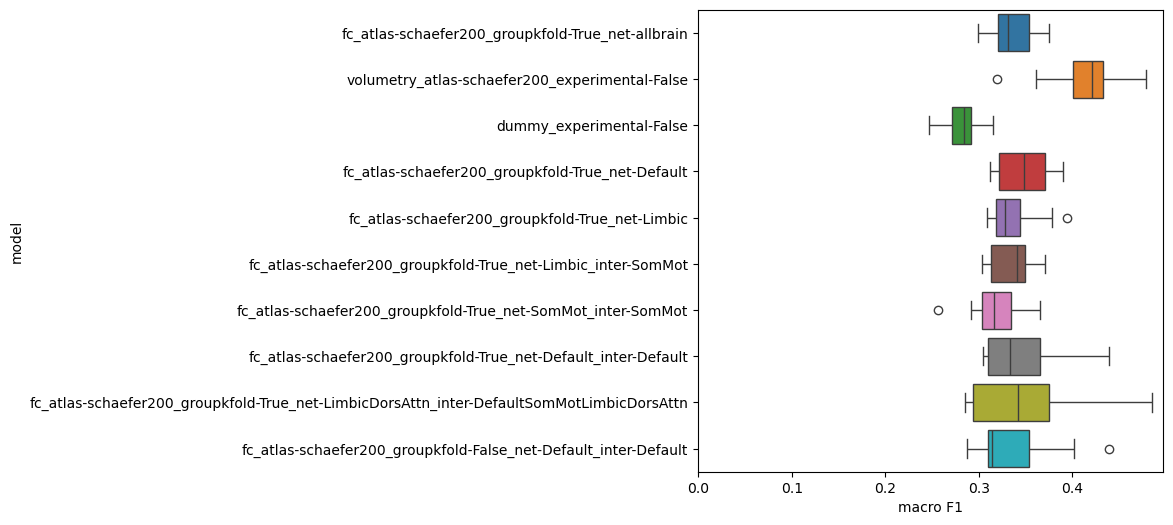

In [47]:
import matplotlib.pyplot as plt
m = df.T.melt(var_name="model", value_name="macro F1")
plt.subplots(figsize=(6, 6))
sns.boxplot(m, x="macro F1", y="model", hue="model")
plt.xlim(0)
plt.show()

## NN inference on test set

In [6]:
import numpy as np
from cogpred.features import make_features
from cogpred.loading import make_test_data, TSFetcher
from neuroginius.atlas import Atlas
ATLAS = "schaefer200"
tspath = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")


In [7]:
atlas = Atlas.from_name(ATLAS)
matrices, metadata = make_test_data(conn_dir, ATLAS, k=3)
net_indexer = np.where(np.array(atlas.macro_labels) == "SomMot", True, False)
net_indexer += np.where(np.array(atlas.macro_labels) == "Limbic", True, False)
fetcher = TSFetcher(tspath)
features = make_features(fetcher, metadata, net_indexer)

Dropping 4 subjects because of lacking MMMSE


In [8]:
y_true = metadata.cluster_label.values.astype(int)

In [9]:
import json
from collections import OrderedDict
from cogpred.models import default_channel_func, initial_bump, slow_increase, fast_increase, constant_channels

EXPDIR = "/homes_unix/jlegrand/data/Memento/output/prediction"
exppath = Path(EXPDIR) / "k-3_feat-series_experimental-True_atlas-schaefer200_winsize-48_batchsize-512_niter-50_stamp-2024-07-12-09:44"
cvres = pd.read_csv(exppath / "cv_results.csv", index_col=0)
with open(exppath / "architecture.json", "r") as file:
    params = json.load(file)

params["module__channel_func"] = eval(params["module__channel_func"])

expdict = dict()
for k in exppath.name.split("_"):
    exptag = k.split("-")
    expdict[exptag[0]] = exptag[1]


In [10]:
from cogpred.models import WindowNetClassifier, BOLDCNN
from torch import nn

new_net = WindowNetClassifier(
    module=BOLDCNN,
    module__n_channels=sum(net_indexer),
    module__window_size=int(expdict["winsize"]),
    criterion=nn.CrossEntropyLoss(),
    **params
)

new_net.initialize()  # This is important!
new_net.load_params(f_params=exppath / "params.pkl")

47 48
94 24
188 12


In [42]:
from matplotlib.backends.backend_pdf import PdfPages
from cogpred.plotting import plot_predictions, plot_ts
label_mapping = ["Stable", "Slow", "Steep"]

def shorten_mapping(mapping):
    for k, v in mapping.items():
        mapping[k] = f"{v:.2f}"
    return mapping

with PdfPages("output/inference.pdf") as pdf:
    for ts, label in zip(features, y_true):
        ts = ts.T
        ts = ts.reshape(1, *ts.shape)
        p, mask = new_net.sliding_inference(ts, stride=6)
        integral = p.sum(axis=1)
        decision = np.argmax(integral)
        mean_values = integral / sum(mask)
        mv_mapping = dict(zip(label_mapping, mean_values))
        mv_mapping = shorten_mapping(mv_mapping)
    
        fig, axes = plt.subplots(2, 1, figsize=(8, 8))
        
        plot_ts(ts.squeeze().T, ax=axes[0])
        plot_predictions(p, axes[1])

        axes[1].set_title(mv_mapping)
        fig.suptitle(
            f"Ground truth : {label_mapping[label]}, Predicted {label_mapping[decision]}"
        )
        fig.tight_layout()
        pdf.savefig()
        plt.close()

    

## All models, inference on test set

In [14]:
from cogpred.loading import make_test_data
matrices, metadata = make_test_data(conn_dir, ATLAS, k)

FileNotFoundError: [Errno 2] No such file or directory: 'data/cluster_stamp-2024-07-11-17:08_labels.csv'

In [ ]:
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec

def make_fc_features(matrices, metadata):
    X = []
    for mat in matrices:
        vec = sym_matrix_to_vec(mat, discard_diagonal=True)
        vec_idx = np.flatnonzero(vec) # Should only be computed once
        X.append(vec[vec_idx])

    X = np.stack(X)
    y = metadata.cluster_label
    assert len(X) == len(y)
    return X, y

In [ ]:
X_test, y_test = make_fc_features(matrices, metadata)

estimators = dict()
for subdir in dir.iterdir():
    try:
        model = joblib.load(subdir / "best_estimator.joblib")
    except FileNotFoundError:
        print(f"{subdir.name} has no available model")
        continue
    except AttributeError:
        print("I hate NN")
    if "experimental-True" not in subdir.name:
        estimators[subdir.name] = model


k-3_feat-fc_atlas-schaefer200 has no available model
k-3_feat-dummy has no available model
I hate NN
k-3_feat-series_experimental-True_atlas-schaefer200 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-04 18:10:38 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 10:30:43 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 11:16:56 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_stamp-2024-07-05 12:13:19 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:00:50 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:02:36 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:06:46 has no available model
k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_stamp-2024-07-05 13:4